<a href="https://colab.research.google.com/github/BankPC/-Training-an-Object-Detection-Model-with-TensorFlow-API-using-Google-COLAB/blob/master/TFODA-Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#    Training an Object Detection Model with TensorFlow API using Google COLAB

> Follow my medium post for the tutorial. https://medium.com/analytics-vidhya/training-an-object-detection-model-with-tensorflow-api-using-google-colab-4f9a688d5e8b

> Now go to Runtime > Change Runtime Type and make sure to select GPU as Hardware accelerator.




Due to the upgrade in the TensorFlow on colab, run the code below. Since object detection API for TensorFlow, 2.0 hasn't been updated as of the time this publication is been reviewed.

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


For the code cell below you should see ‘Found GPU’ and tf version 1.x. Else remember to change runtime to GPU

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


###Sign in with the same Google account used for the google-drive and create a new notebook.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd '/content/gdrive/My Drive/Desktop/'

/content/gdrive/My Drive/Desktop


Clome the Tensorflow API repo

In [0]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


Install some needed tools and dependencies.

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
python-pil is already the newest version (5.1.0-1ubuntu0.2).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
%cd /content/gdrive/My Drive/Desktop/models/research/
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/My Drive/Desktop/models/research


In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/Desktop/models/research/:/content/gdrive/My Drive/Desktop/models/research/slim'

Always run the cell below for every session restart

In [0]:
!python setup.py build
!python setup.py install

running build
running build_py
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/mean_stddev_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/model_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/multiscale_anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/optimizer_pb2.py -> build/l

Check thr remaining time allowed for the session you are runing. Depending on your data try to know the number of hours that will be enough. If the time is lesser then restart the session. NB the time result you see in in hours

In [0]:
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

Time remaining for this session is:  11.329561291734377


Run Code below to see if all we need for the training has been installed.

In [0]:
#rember the last CD you did in order to specify the directory.
%cd /content/gdrive/My Drive/Desktop/models/research/object_detection/builders/
!python model_builder_test.py

/content/gdrive/My Drive/Desktop/models/research/object_detection/builders
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ]

Change Directory to object detection folder

In [0]:
%cd /content/gdrive/My Drive/Desktop/models/research/object_detection/

/content/gdrive/My Drive/Desktop/models/research/object_detection


Run the cell bolw to generate your CSV file

In [0]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
def main(directory_list):
    for Image_cat in directory_list:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(Image_cat))
        xml_df = xml_to_csv(image_path) 
        xml_df.to_csv('data/{}_labels.csv'.format(Image_cat), index=None)
        print('Successfully converted xml to csv.')
main(['train','test'])

Successfully converted xml to csv.
Successfully converted xml to csv.


Create a python file named generate_tfrecord.py then copy, edit the necessary parts, or simply paste the code below in the python file then upload it into the object detection directory if the same configs applies to you 

```
"""
Usage:
# Create train data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/train_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/train.record
# Create test data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/test_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import os
import io
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("../../models/research")
from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict
flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('label', '', 'Name of class label')
# if your image has more labels input them as
# flags.DEFINE_string('label0', '', 'Name of class[0] label')
# flags.DEFINE_string('label1', '', 'Name of class[1] label')
# and so on.
flags.DEFINE_string('img_path', '', 'Path to images')
FLAGS = flags.FLAGS
# TO-DO replace this with label map
# for multiple labels add more else if statements
def class_text_to_int(row_label):
    if row_label == FLAGS.label:  # 'ship':
        return 1
    # comment upper if statement and uncomment these statements for multiple labelling
    # if row_label == FLAGS.label0:
    #   return 1
    # elif row_label == FLAGS.label1:
    #   return 0
    else:
        None
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]
def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example
def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(os.getcwd(), FLAGS.img_path)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))
if __name__ == '__main__':
    tf.compat.v1.app.run()
```



###generate the train record

In [0]:
!python generate_tfrecord.py --label='ARDUINO DEVICE' --csv_input=data/train_labels.csv --output_path=data/train.record --img_path=images/train


W0417 11:22:36.895809 139887728387968 module_wrapper.py:139] From generate_tfrecord.py:101: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0417 11:22:37.851239 139887728387968 module_wrapper.py:139] From generate_tfrecord.py:59: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/Desktop/models/research/object_detection/data/train.record


###generate the test record

In [0]:
!python generate_tfrecord.py --label='ARDUINO DEVICE' --csv_input=data/test_labels.csv --output_path=data/test.record --img_path=images/test


W0417 11:23:39.295871 140197394098048 module_wrapper.py:139] From generate_tfrecord.py:101: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0417 11:23:39.879151 140197394098048 module_wrapper.py:139] From generate_tfrecord.py:59: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/Desktop/models/research/object_detection/data/test.record


Get the pre-trained Object detection model from TensorFlow with the code below

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
!tar -xvf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

--2020-04-17 11:23:48--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.76.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128048406 (122M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz.1’

ssd_mobilenet_v1_co 100%[===================>] 122.12M  43.3MB/s    in 2.8s    

2020-04-17 11:23:51 (43.3 MB/s) - ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz.1’ saved [128048406/128048406]

ssd_mobilenet_v1_coco_11_06_2017/
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta
ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt


You can simply copy the code in this snipet below paste in a new text file and save as "ssd_mobilenet_v1_coco.config"




```
# SSD with Mobilenet v1 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.
model {
  ssd {
    num_classes:90  #number of classes to be trained. in my case 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v1'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
          anchorwise_output: true
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}
train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "ssd_mobilenet_v1_coco_11_06_2017/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  #num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}
train_input_reader: {
  tf_record_input_reader {
    input_path: "data/train.record"
  }
  label_map_path: "training/object-detection.pbtxt"
}
eval_config: {
    # (Optional): Uncomment the line below if you installed the Coco evaluation tools
    # and you want to also run evaluation
    # metrics_set: "coco_detection_metrics"
    # (Optional): Set this to the number of images in your <PATH_TO_IMAGES_FOLDER>/train
    # if you want to also run evaluation
    num_examples: 8000
    # Note: The below line limits the evaluation process to 10 evaluations.
    # Remove the below line to evaluate indefinitely.
    max_evals: 10
}
eval_input_reader: {
  tf_record_input_reader {
    input_path: "data/test.record"
  }
  label_map_path: "training/object-detection.pbtxt"
  shuffle: false
  num_readers: 1
```



#OR

In [0]:
!wget https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config

--2020-04-17 11:24:01--  https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘ssd_mobilenet_v1_coco.config.1’

ssd_mobilenet_v1_co     [ <=>                ] 113.49K  --.-KB/s    in 0.01s   

2020-04-17 11:24:02 (8.37 MB/s) - ‘ssd_mobilenet_v1_coco.config.1’ saved [116209]



ALWAYS CHECK TIME

In [0]:
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

Time remaining for this session is:  11.169388231039047


Just to check. LOL this things can be fumy at times LMAO

In [0]:
pip install tensorboardcolab

Ensure to run the code cell below first

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


IF you want to keep track of your model loss it best to run tensor board in background just like this before you run your training

In [0]:
%tensorboard --logdir training/

<IPython.core.display.Javascript object>

Ensure to copy train.py file from Legacy folder in your google drive to the object detection folder itself before runnning the cell below

In [0]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=ssd_mobilenet_v1_coco.config

Streaming output truncated to the last 5000 lines.
I0417 11:40:40.594107 139962961323904 learning.py:507] global step 4646: loss = 0.6355 (0.688 sec/step)
INFO:tensorflow:global step 4647: loss = 0.6549 (0.719 sec/step)
I0417 11:40:41.314867 139962961323904 learning.py:507] global step 4647: loss = 0.6549 (0.719 sec/step)
INFO:tensorflow:global step 4648: loss = 0.6918 (0.759 sec/step)
I0417 11:40:42.075911 139962961323904 learning.py:507] global step 4648: loss = 0.6918 (0.759 sec/step)
INFO:tensorflow:global step 4649: loss = 0.7828 (0.676 sec/step)
I0417 11:40:42.753121 139962961323904 learning.py:507] global step 4649: loss = 0.7828 (0.676 sec/step)
INFO:tensorflow:global step 4650: loss = 0.6700 (0.730 sec/step)
I0417 11:40:43.484166 139962961323904 learning.py:507] global step 4650: loss = 0.6700 (0.730 sec/step)
INFO:tensorflow:global step 4651: loss = 0.8266 (0.823 sec/step)
I0417 11:40:44.308877 139962961323904 learning.py:507] global step 4651: loss = 0.8266 (0.823 sec/step)


##EXporting inference graph

In [0]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix training/model.ckpt-6602 --output_directory trained_inference_graph/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0417 12:30:30.306665 140398788626304 module_wrapper.py:139] From export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0417 12:30:30.314913 140398788626304 module_wrapper.py:139] From /content/gdrive/My Drive/Desktop/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0417 12:30:30.315358 140398788626304 module_wrapper.py:139] From /content/gdrive/My Drive/Desktop/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder 

##ZIPPing the EXported graph

In [0]:
!zip -r Arduino_exp_graph.zip trained_inference_graph

  adding: trained_inference_graph/ (stored 0%)
  adding: trained_inference_graph/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: trained_inference_graph/model.ckpt.index (deflated 68%)
  adding: trained_inference_graph/checkpoint (deflated 42%)
  adding: trained_inference_graph/model.ckpt.meta (deflated 93%)
  adding: trained_inference_graph/frozen_inference_graph.pb (deflated 9%)
  adding: trained_inference_graph/saved_model/ (stored 0%)
  adding: trained_inference_graph/saved_model/variables/ (stored 0%)
  adding: trained_inference_graph/saved_model/saved_model.pb (deflated 9%)
  adding: trained_inference_graph/pipeline.config (deflated 69%)


#LETS TEST OUR MODEL AND SEE RESULT

> Copy about 9 images in the test_images folder and rename each to imagesX.jpg with X being a number from 1 to 9 before running the code below.



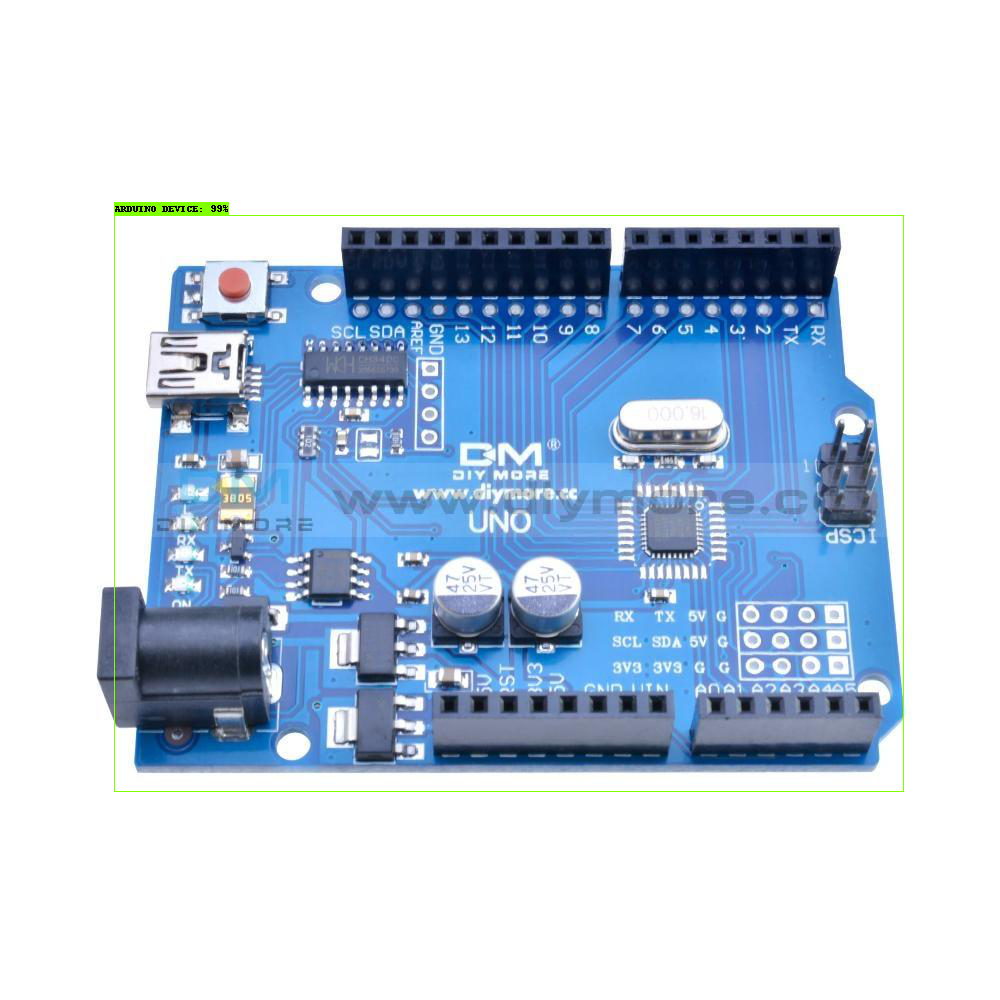

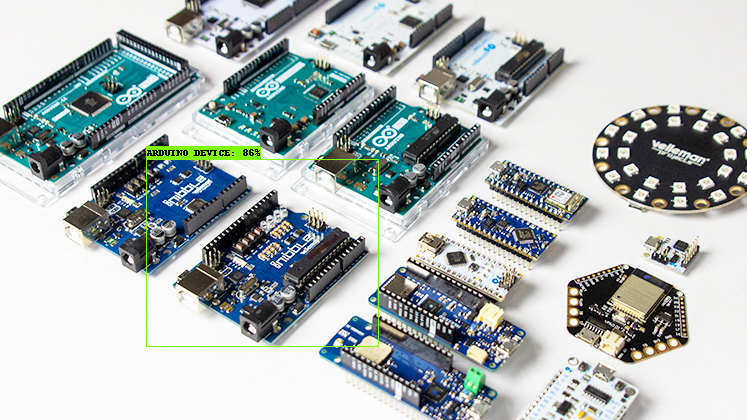

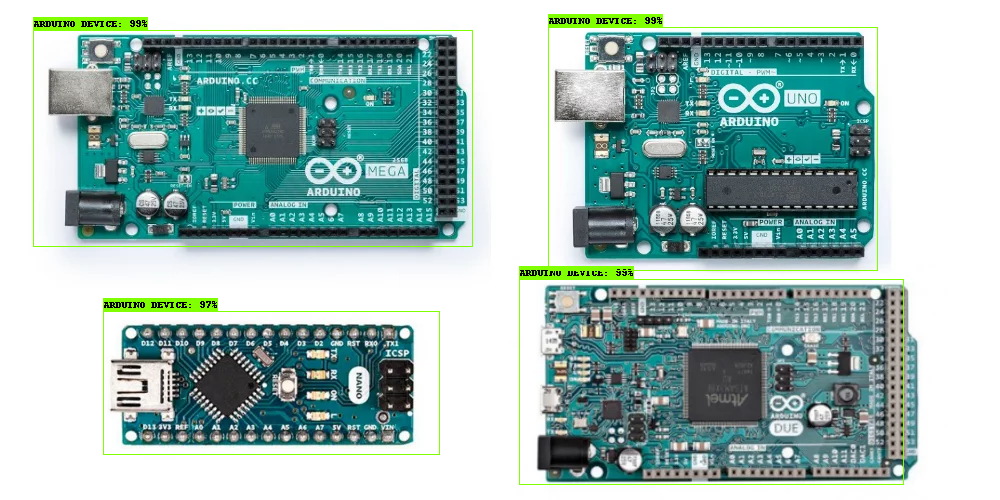

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util



### Model preparation variable
MODEL_NAME = 'trained_inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/object-detection.pbtxt'
NUM_CLASSES = 1 #remember number of objects you are training? cool.


### Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


###Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)




### Load image into numpy function
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




###STATING THE PATH TO IMAGES TO BE TESTED
PATH_TO_TEST_IMAGES_DIR = 'test_images/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]
IMAGE_SIZE = (12, 8)




### Function to run inference on a single image which will later be used in an iteration
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict



### To iterate on each image in the test image path defined 
### NB define the range of numbers and let it match the number of imAGES IN TEST FOLDER +1
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
  display(Image.fromarray(image_np))
  

